In [100]:
import numpy as np
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
from scipy import optimize
from pandas import DataFrame
import math
import scipy.optimize as opt

data = np.loadtxt("./data/lateral_calibration.csv",delimiter=",")   
data = np.array([data])

%matplotlib inline

# Importing and Plotting Data

To get an initial understanding of the experimental setup, we calibrate our system with a 1D data scan with lightly radioactive materials place at the center. This allows to understand the necessary amount of data cleaning required and the general geometric calibration of the system.

First we initialize the polar geometry and plot the data

In [101]:
angles = []
angle_step = 10
for i in range(len(data)):
    angles.append(i*angle_step)
print('Angles:',angles)

Angles: [0]


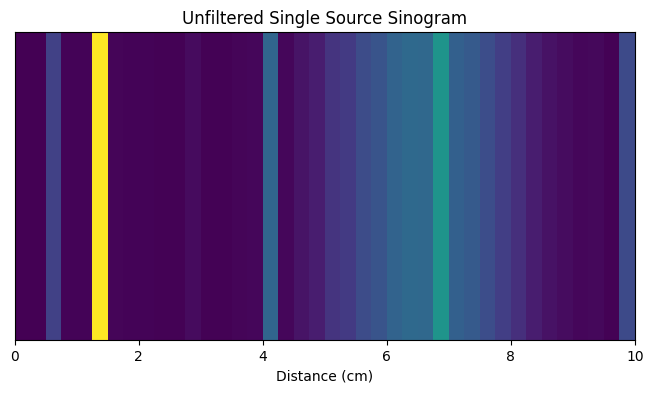

In [102]:
fig,ax = plt.subplots(figsize = (8,4))
start_dist = 0
end_dist = 10
start_angle = 1
end_angle = angles[-1]  # This is the last angle in the array, no matter how many angles are in it.
ax.imshow(data,extent=[start_dist,end_dist,end_angle,start_angle],aspect="auto")
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Angle (degrees)")
ax.get_yaxis().set_visible(False)
ax.set_title("Unfiltered Single Source Sinogram");

#fig.savefig('1-source_sinogram.png')
plt.show()

We introduce some light data smoothing by using a 1D array smoothing function and introduce function fitting capabilities to identify feature locations using statistical fitting:

In [103]:
#this is our data fitting function for feature location identification

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), -1, -1
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), -1, -1
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    pfcov = cov[0,1]
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq, dof

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

def gaussianfunc_bg(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))+p[3]*x+p[4]

#we can include a data smoothing function that allows us to applying localized signal smoothing

def get_avg(list,i):
    sum = 0
    div = 0
    for offset_i in [-1,0,1]:
        new_i = i + offset_i
        if (new_i >= 0 and new_i < len(list)):
            sum += list[new_i]
            div += 1
    avg = (sum - list[i])/(div-1)
    return avg

def n_avg(list, i, j):
    sum = 0
    div = 0
    for offset_i in [-1,0, 1]:
        for offset_j in [-1,0, 1]:
            new_i = i + offset_i
            new_j = j + offset_j
            if (new_i >= 0 and new_j >= 0 and new_i < len(list) and new_j < len(list)):
                sum += list[new_i][new_j]
                div += 1
    avg = (sum-list[i][j]) / (div-1)
    return avg

def smoothing(list):
    for x in range(0,len(list)):
        if list[x] > 1.25*get_avg(list,x):
            list[x] = get_avg(list,x)
    return(list)

In [104]:
smoothing(data[0])

array([ 27. ,  31. ,  36.5,  42. ,  42. ,  48. ,  54. ,  45. ,  47. ,
        37. ,  40. ,  39. ,  38. ,  40. ,  56. ,  59. ,  58.5,  58. ,
       128. , 176. , 309. , 346. , 464. , 518. , 625. , 669. , 663. ,
       633. , 603. , 556. , 467. , 373. , 282. , 176. , 117. ,  90. ,
        61. ,  50. ,  39. ,  39. ])

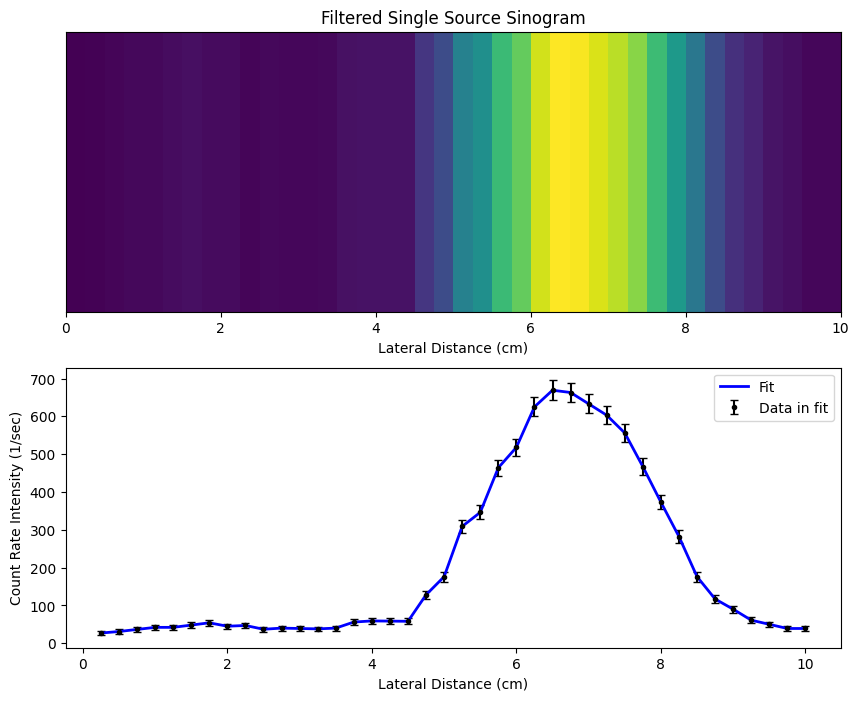

In [116]:
fig,ax = plt.subplots(2,figsize=(10,8))
start_dist = 0
end_dist = 10
start_angle = 1
end_angle = angles[-1]  # This is the last angle in the array, no matter how many angles are in it.
ax[0].imshow(data,extent=[start_dist,end_dist,end_angle,start_angle],aspect="auto")
ax[0].set_xlabel('Lateral Distance (cm)')
ax[0].set_ylabel("Angle (degrees)")
ax[0].get_yaxis().set_visible(False)
ax[0].set_title("Filtered Single Source Sinogram");

######### Poisson statistics ########
y = data[0]
dy = np.sqrt(y)

x = []
step = 0.25
while step <=10:
    x.append(step)
    step += 0.25
x = np.array(x)

ax[1].errorbar(x, y, yerr = dy,fmt= 'k.', capsize = 3, label='Data in fit')
ax[1].plot(x, y, color = 'blue', linewidth = 2, label='Fit')
ax[1].set_xlabel('Lateral Distance (cm)')
ax[1].set_ylabel('Count Rate Intensity (1/sec)')
ax[1].legend()

We can then write a data fitting function that allows us to fit various functions/models. Applying Poisson statistics allows us to account for the limited resolution we are operating with. 


Converged with chi-squared 20.99
Number of degrees of freedom, dof = 16.00
Reduced chi-squared 1.31

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 2.000e+03                | 1.952e+03                | 8.019e+01               
1           | 6.750e+00                | 6.702e+00                | 2.389e-02               
2           | 1.000e+00                | 1.122e+00                | 3.226e-02               
3           | 1.000e+01                | 1.017e+01                | 3.109e+00               
4           | 1.000e+01                | -8.472e+01               | 3.200e+01               
[4.5       4.5010002 4.5020004 ... 9.4979996 9.4989998 9.5      ]


Text(0, 0.5, 'Count Rate Intensity (1/sec)')

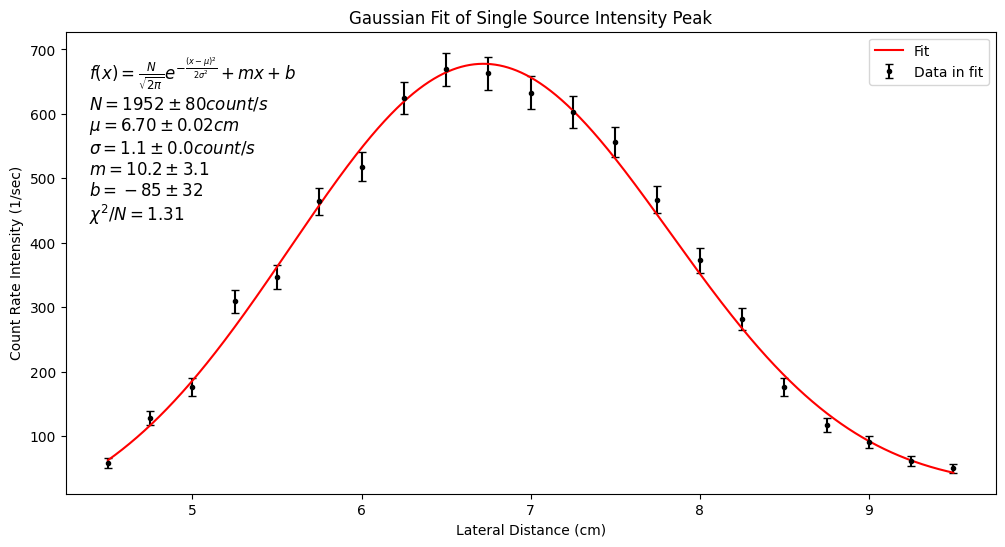

In [118]:
guess = [2000,6.75,1,10,10]

min_value = 17
max_value = 38

pf, pferr, chisq, dof = data_fit(guess, gaussianfunc_bg, x[min_value:max_value], y[min_value:max_value], dy[min_value:max_value])

fig,ax = plt.subplots(figsize = (12,6))

ax.errorbar(x[min_value:max_value], y[min_value:max_value], yerr=dy[min_value:max_value],fmt= 'k.', capsize = 3, label='Data in fit')
channel_cont = np.linspace(min(x[min_value:max_value]), max(x[min_value:max_value]), 5000)

print(channel_cont)
ax.plot(channel_cont, gaussianfunc_bg(pf, channel_cont), 'r-', label='Fit')


#f(x) = \frac{N}{\sqrt{2\pi }}e^{-\frac{(x-\mu)^2}{2\sigma^2 }}
textfit = '$f(x) = \\frac{N}{\sqrt{2\pi }}e^{-\\frac{(x-\mu)^2}{2\sigma^2 }}+mx+b$\n' 
textfit += '$N = {:.0f} \pm {:.0f} count/s$ \n'.format(pf[0],pferr[0]) 
textfit += '$\mu = {:.2f} \pm {:.2f} cm$ \n'.format(pf[1],pferr[1]) 
textfit += '$\sigma = {:.1f} \pm {:.1f} count/s$ \n'.format(pf[2],pferr[2])
textfit += '$m = {:.1f} \pm {:.1f}$ \n'.format(pf[3],pferr[3]) 
textfit += '$b = {:.0f} \pm {:.0f}$ \n'.format(pf[4],pferr[4]) 
textfit += '$\chi^2 / N = {:.2f}$ \n'.format(chisq/dof) 
ax.text(0.025, 0.95, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')

ax.set_title('Gaussian Fit of Single Source Intensity Peak')
ax.legend()
ax.set_xlabel('Lateral Distance (cm)')
ax.set_ylabel('Count Rate Intensity (1/sec)')

This initial calibration shows us the accuracy to which we can accurately identify nuclear features with accuracy of $\pm0.02$cm.